## Beam map of SO MF Feedhorn Arrays

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numpy import genfromtxt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

%matplotlib inline

matplotlib.rcParams["font.family"] = "Helvetica Neue"
matplotlib.rcParams["font.size"] = 22
matplotlib.rcParams.update({"axes.grid" : True, "grid.color": "grey", "grid.alpha": .2, 'xtick.direction':'in','ytick.direction':'in'})
%config InlineBackend.figure_format = 'retina'

e_col = '#e42536'
h_col = '#570efc'
c_col = '#f89c20'

w_mf2 = np.loadtxt('sim/MF_2.txt')
w_mf1 = np.loadtxt('sim/MF_1.txt')

Define function to read in data and cooresponding simulation

In [2]:
def beam_plot(freq,anglee,date,c):   #first beam plotting function

    csv='sim/v11_3_cross.csv'                                   #filename for simulated data from csv
    data2 = genfromtxt(csv, delimiter=',', skip_header=1)       #read file into memory
    theta=data2[:,0]
    theta_r=theta[::-1]*-1.
    theta_full=np.concatenate([theta_r,theta])
                                                                #whether or not the data2 includes Ccut of phi
    if c==1:
        name=['Ecut','Hcut','Ccut']
    else:
        name=['Ecut','Hcut']
                                                                #
    E_ind=(freq-70)*3+1     #X phi=0
    H_ind=(freq-70)*3+3     #X phi=90
    C_ind=(freq-70)*3+320   #Y phi=45
    shift=np.zeros(2)
    top=np.zeros(2)        

    def running_mean(x, N):                                             #we use a running mean to increase SNR
            return np.convolve(x, np.ones((N,))/N)[(N-1):]

    for jj in range(len(name)):     #loop for each cut in the csv

        data=np.loadtxt('data/'+str(freq)+'GHz_'+str(anglee)+'deg_'+str(name[jj])+'_'+date+'.txt')
        ang=(len(data)-1) /2
        ang=np.linspace(-ang,ang,len(data))
        L_MEAN = 1
        N_INDIV = 5
        L=len(data[0,:])

        line_size = np.size(data[0])
        nsamp =  np.size(data,0)    #number of rows in data
        arr_f = np.zeros(nsamp)
        arr_x = np.zeros(nsamp)
        arr_y = np.zeros(nsamp)
        arr_phi = np.zeros(nsamp)
        amp_cross=np.zeros(nsamp)
        amp_phase=np.zeros(nsamp)
        amp_var=np.zeros(nsamp)
        phase=np.zeros(nsamp)
        z=[]

        i_AA_begin = int(N_INDIV + (1-1)*(line_size-N_INDIV)/4)
        i_AA_end= int(N_INDIV + (2-1)*(line_size-N_INDIV)/4) -1
        i_BB_begin = int(N_INDIV + (2-1)*(line_size-N_INDIV)/4)
        i_BB_end= int(N_INDIV + (3-1)*(line_size-N_INDIV)/4) -1
        i_AB_begin = int(N_INDIV + (3-1)*(line_size-N_INDIV)/4)
        i_AB_end= int(N_INDIV + (4-1)*(line_size-N_INDIV)/4) -1
        i_phase_begin = int(N_INDIV + (4-1)*(line_size-N_INDIV)/4)
        i_phase_end= int(N_INDIV + (5-1)*(line_size-N_INDIV)/4) -1


        for kk in range(nsamp):
            #take in raw DATA
            arr_f[kk] = data[kk][0]
            arr_x[kk] = data[kk][1]
            arr_y[kk] = data[kk][2]
            arr_phi[kk] = data[kk][3]
            index_signal = data[kk][4]
            arr_AA = np.array(running_mean(data[kk][i_AA_begin : i_AA_end],L_MEAN))
            arr_BB = np.array(running_mean(data[kk][i_BB_begin : i_BB_end],L_MEAN))
            arr_AB = np.array(running_mean(data[kk][i_AB_begin : i_AB_end],L_MEAN))
            arr_phase = np.array( data[kk][i_phase_begin : i_phase_end] )
            n_channels = np.size(arr_AB)

            #make amplitude arrays, in case they need to be plotted.
            amp_cross[kk] = arr_AB[int(n_channels/2)]
            amp_var[kk] = np.power( np.divide(arr_AB[int(n_channels/2)],arr_AA[int(n_channels/2)]) , 2)
            amp_phase[kk] = np.remainder(arr_phase[int(n_channels/2)],360.)

        power=amp_cross

        #Convert angle to angle of setup
        def func(x,a, b, c):  #fits a parabola to center of the data (recenters data to align with simulation)
            return a*(x-b)**2+c
        pguess=[-1.e3, 0.,1.e8]

        if jj==0:
            angle=ang
            popt,pcov=curve_fit(func,angle[(angle<20) & (angle>-20)],power[(angle<20) & (angle>-20)], p0=pguess)
            beam_center_a=popt[1]
            norm=popt[2]
            shift[0]=popt[1]
            top[0]=popt[2]
            norm_a=np.max(power)
            final_angle_a=angle-beam_center_a
            final_power_a=10*np.log10(power**2/norm**2)

        if jj==1:
            angle=ang
            popt,pcov=curve_fit(func,angle[(angle<20) & (angle>-20)],power[(angle<20) & (angle>-20)], p0=pguess)
            beam_center=popt[1]
            norm=popt[2]
            shift[1]=popt[1]
            top[1]=popt[2]
            norm_b=np.max(power)
            final_angle_b=angle-beam_center
            final_power_b=10*np.log10(power**2/norm**2)  

        if c==1:
            if jj==2:
                angle_c=np.sqrt(2)*ang
                beam_center_c=beam_center_a
                norm_c=norm_a
                final_angle_c=angle_c-beam_center_a
                final_power_c=10*np.log10(power**2/norm**2)

    E=data2[:,E_ind]
    H=data2[:,H_ind]
    N=np.max(E)
    N_H=np.max(H)
    E_norm=E-N
    H_norm=H-N_H
    E_ind+=3*5
    H_ind+=3*5
    E_r=E_norm[::-1]
    H_r=H_norm[::-1]
    E_full=np.concatenate([E_r,E_norm])
    H_full=np.concatenate([H_r,H_norm])

    if c==1:
        C=data2[:,C_ind]
        C_norm=C-N
        C_ind+=3*5
        C_r=C_norm[::-1]
        C_full=np.concatenate([C_r,C_norm])
        
    if c==0:
        return theta_full,H_full,E_full,final_angle_a,final_power_a,final_angle_b,final_power_b
    else:
        return theta_full,H_full,E_full,C_full,final_angle_a,final_power_a,final_angle_b,final_power_b,final_angle_c,final_power_c

findfont: Font family ['Helvetica Neue'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica Neue'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica Neue'] not found. Falling back to DejaVu Sans.


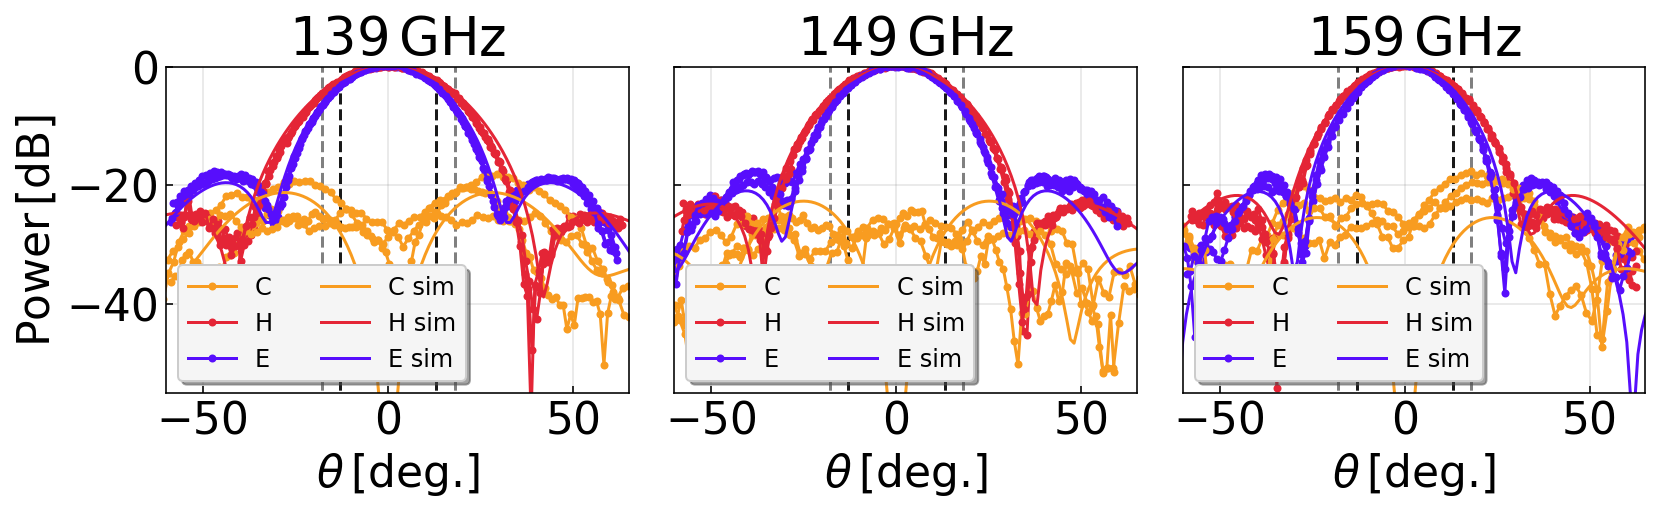

In [3]:
freq = [139,149,159]
c_opt = 1
date_B = '21-1-2021'
date_A = '22-1-2021'
date_C = '23-1-2021'

thet_sim, e_sim1,h_sim1,c_sim1,thet_e1_A,e1_A,thet_h1_A,h1_A,thet_c1_A,c1_A = beam_plot(freq[0],60,date_A,c_opt)
thet_sim, e_sim1,h_sim1,c_sim1,thet_e1_B,e1_B,thet_h1_B,h1_B,thet_c1_B,c1_B = beam_plot(freq[0],60,date_B,c_opt)
thet_sim, e_sim1,h_sim1,c_sim1,thet_e1_C,e1_C,thet_h1_C,h1_C,thet_c1_C,c1_C = beam_plot(freq[0],60,date_C,c_opt)

thet_sim, e_sim2,h_sim2,c_sim2,thet_e2_A,e2_A,thet_h2_A,h2_A,thet_c2_A,c2_A = beam_plot(freq[1],60,date_A,c_opt)
thet_sim, e_sim2,h_sim2,c_sim2,thet_e2_B,e2_B,thet_h2_B,h2_B,thet_c2_B,c2_B = beam_plot(freq[1],60,date_B,c_opt)
thet_sim, e_sim2,h_sim2,c_sim2,thet_e2_C,e2_C,thet_h2_C,h2_C,thet_c2_C,c2_C = beam_plot(freq[1],60,date_C,c_opt)

thet_sim, e_sim3,h_sim3,c_sim3,thet_e3_A,e3_A,thet_h3_A,h3_A,thet_c3_A,c3_A = beam_plot(freq[2],60,date_A,c_opt)
thet_sim, e_sim3,h_sim3,c_sim3,thet_e3_B,e3_B,thet_h3_B,h3_B,thet_c3_B,c3_B = beam_plot(freq[2],60,date_B,c_opt)
thet_sim, e_sim3,h_sim3,c_sim3,thet_e3_C,e3_C,thet_h3_C,h3_C,thet_c3_C,c3_C = beam_plot(freq[2],60,date_C,c_opt)


fig, axs = plt.subplots(1, 3,figsize = (12,4),sharey=True)

e_col = '#e42536'
h_col = '#570efc'
c_col = '#f89c20'

axs[0].plot(thet_c1_B,c1_B,'.-',color = c_col,label = 'C')
axs[0].plot(thet_e1_B,e1_B,'.-',color = e_col,label = 'H')
axs[0].plot(thet_h1_B,h1_B,'.-',color = h_col,label = 'E')
axs[0].plot(thet_h1_A,c1_A,'.-',color = c_col)
axs[0].plot(thet_e1_A,e1_A,'.-',color = e_col)
axs[0].plot(thet_h1_A,h1_A,'.-',color = h_col)
axs[0].plot(thet_c1_C,c1_C,'.-',color = c_col)
axs[0].plot(thet_e1_C,e1_C,'.-',color = e_col)
axs[0].plot(thet_h1_C,h1_C,'.-',color = h_col)
axs[0].plot(thet_sim,c_sim1,color = c_col,label = 'C sim')
axs[0].plot(thet_sim,e_sim1,color = e_col,label = 'H sim')
axs[0].plot(thet_sim,h_sim1,color = h_col,label = 'E sim')

axs[0].set_title("%d$\,$GHz" %freq[0])

axs[1].plot(thet_c2_B,c2_B,'.-',color = c_col,label = 'C')
axs[1].plot(thet_e2_B,e2_B,'.-',color = e_col,label = 'H')
axs[1].plot(thet_h2_B,h2_B,'.-',color = h_col,label = 'E')
axs[1].plot(thet_h2_A,c2_A,'.-',color = c_col)
axs[1].plot(thet_e2_A,e2_A,'.-',color = e_col)
axs[1].plot(thet_h2_A,h2_A,'.-',color = h_col)
axs[1].plot(thet_c2_C,c2_C,'.-',color = c_col)
axs[1].plot(thet_e2_C,e2_C,'.-',color = e_col)
axs[1].plot(thet_h2_C,h2_C,'.-',color = h_col)
axs[1].plot(thet_sim,c_sim2,color = c_col,label = 'C sim')
axs[1].plot(thet_sim,e_sim2,color = e_col,label = 'H sim')
axs[1].plot(thet_sim,h_sim2,color = h_col,label = 'E sim')

axs[1].set_title("%d$\,$GHz" %freq[1])
axs[2].plot(thet_c3_B,c3_B,'.-',color = c_col,label = 'C')
axs[2].plot(thet_e3_B,e3_B,'.-',color = e_col,label = 'H')
axs[2].plot(thet_h3_B,h3_B,'.-',color = h_col,label = 'E')
axs[2].plot(thet_c3_A,c3_A,'.-',color = c_col)
axs[2].plot(thet_e3_A,e3_A,'.-',color = e_col)
axs[2].plot(thet_h3_A,h3_A,'.-',color = h_col)
axs[2].plot(thet_c3_C,c3_C,'.-',color = c_col)
axs[2].plot(thet_e3_C,e3_C,'.-',color = e_col)
axs[2].plot(thet_h3_C,h3_C,'.-',color = h_col)
axs[2].plot(thet_sim,c_sim3,color = c_col,label = 'C sim')
axs[2].plot(thet_sim,e_sim3,color = e_col,label = 'H sim')
axs[2].plot(thet_sim,h_sim3,color = h_col,label = 'E sim')

axs[2].set_title("%d$\,$GHz" %freq[2])

axs[0].set_xlabel(r"$\theta\,$[deg.]")
axs[1].set_xlabel(r"$\theta\,$[deg.]")
axs[2].set_xlabel(r"$\theta\,$[deg.]")
axs[0].set_ylabel("Power$\,$[dB]")
axs[0].set_ylabel("Power$\,$[dB]")

axs[0].set_xlim(-60,65)
axs[0].set_ylim(-55,0)
axs[1].set_xlim(-60,65)
axs[1].set_ylim(-55,0)
axs[2].set_xlim(-60,65)
axs[2].set_ylim(-55,0)

lab_size = 12
axs[0].legend(ncol=2,fontsize = lab_size,loc = 3,shadow=True, facecolor="whitesmoke")
axs[1].legend(ncol=2,fontsize = lab_size,loc = 3,shadow=True, facecolor="whitesmoke")
axs[2].legend(ncol=2,fontsize = lab_size,loc = 3,shadow=True, facecolor="whitesmoke")

axs[0].vlines(x=18,ymin = -60,ymax = 10,linestyle = 'dashed',color = 'grey')
axs[0].vlines(x=-18,ymin = -60,ymax = 10,linestyle = 'dashed',color = 'grey')
axs[1].vlines(x=18,ymin = -60,ymax = 10,linestyle = 'dashed',color = 'grey')
axs[1].vlines(x=-18,ymin = -60,ymax = 10,linestyle = 'dashed',color = 'grey')
axs[2].vlines(x=18,ymin = -60,ymax = 10,linestyle = 'dashed',color = 'grey')
axs[2].vlines(x=-18,ymin = -60,ymax = 10,linestyle = 'dashed',color = 'grey')

axs[0].vlines(x=13,ymin = -60,ymax = 10,linestyle = 'dashed',color = 'k',alpha = .9)
axs[0].vlines(x=-13,ymin = -60,ymax = 10,linestyle = 'dashed',color = 'k',alpha = .9)
axs[1].vlines(x=13,ymin = -60,ymax = 10,linestyle = 'dashed',color = 'k',alpha = .9)
axs[1].vlines(x=-13,ymin = -60,ymax = 10,linestyle = 'dashed',color = 'k',alpha = .9)
axs[2].vlines(x=13,ymin = -60,ymax = 10,linestyle = 'dashed',color = 'k',alpha = .9)
axs[2].vlines(x=-13,ymin = -60,ymax = 10,linestyle = 'dashed',color = 'k',alpha = .9)

plt.tight_layout(w_pad=0.7)
plt.show()

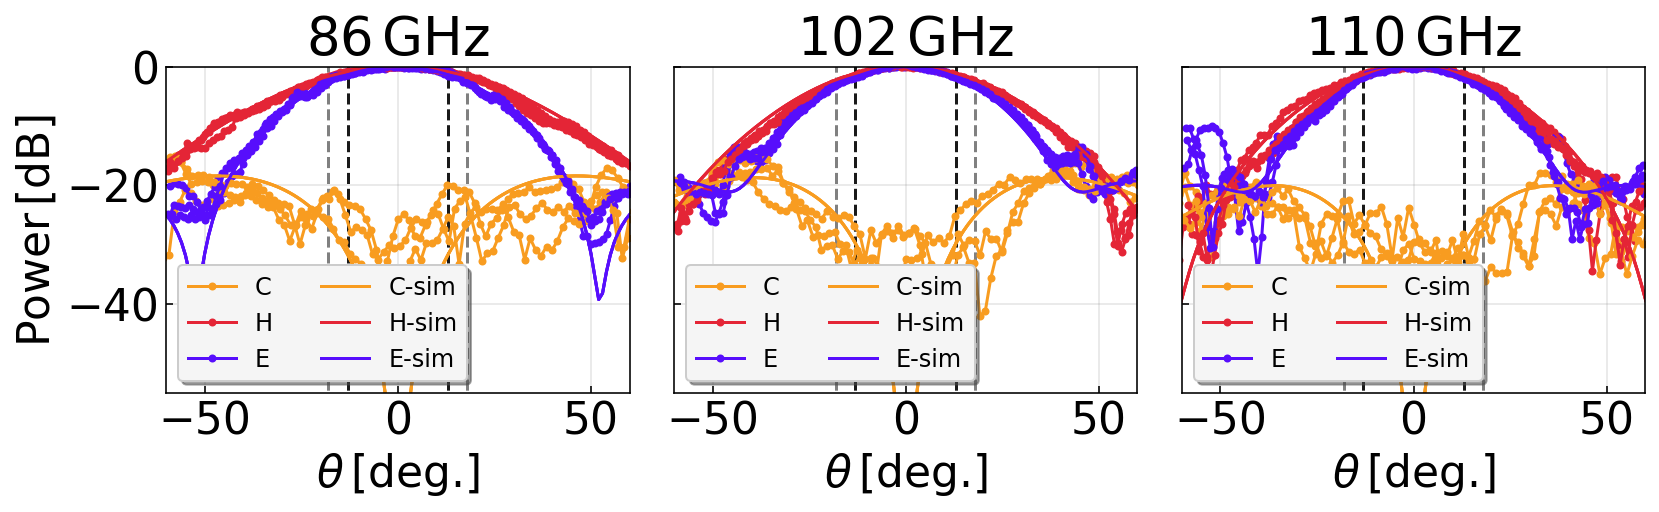

In [20]:
freq = [86,102,110]

c_opt = 0

date_D = '10-2-2021'
date_C = '11-2-2021'
date_B = '12-2-2021'
fig, axes = plt.subplots(1, 3,figsize = (12,4),sharey=True)


for ii in range(len(freq)):
    thet_sim, e_sim1,h_sim1,c_sim1,thet_e1_A,e1_A,thet_h1_A,h1_A,thet_c1_A,c1_A = beam_plot(freq[ii],60,date_D,1)
    
    axes[ii].set_title(str(freq[ii])+"$\,$GHz")
    
    axes[ii].plot(thet_c1_A,c1_A,'.-',color = c_col,label = 'C')    
    axes[ii].plot(thet_e1_A,e1_A,'.-',color = e_col,label = 'H')
    axes[ii].plot(thet_h1_A,h1_A,'.-',color = h_col,label = 'E')
    axes[ii].plot(thet_sim, c_sim1,color = c_col,label = 'C-sim')
    axes[ii].plot(thet_sim, e_sim1,color = e_col,label = 'H-sim')
    axes[ii].plot(thet_sim, h_sim1,color = h_col,label = 'E-sim')

    thet_sim, e_sim1,h_sim1,c_sim1,thet_e1_A,e1_A,thet_h1_A,h1_A,thet_c1_A,c1_A = beam_plot(freq[ii],60,date_C,1)
    
    axes[ii].plot(thet_c1_A,c1_A,'.-',color = c_col)    
    axes[ii].plot(thet_e1_A,e1_A,'.-',color = e_col)
    axes[ii].plot(thet_h1_A,h1_A,'.-',color = h_col)
    axes[ii].plot(thet_sim, c_sim1,color = c_col)
    axes[ii].plot(thet_sim, e_sim1,color = e_col)
    axes[ii].plot(thet_sim, h_sim1,color = h_col)

    thet_sim, e_sim1,h_sim1,c_sim1,thet_e1_A,e1_A,thet_h1_A,h1_A,thet_c1_A,c1_A = beam_plot(freq[ii],60,date_B,1)
    
    axes[ii].plot(thet_c1_A,c1_A,'.-',color = c_col)    
    axes[ii].plot(thet_e1_A,e1_A,'.-',color = e_col)
    axes[ii].plot(thet_h1_A,h1_A,'.-',color = h_col)
    axes[ii].plot(thet_sim, c_sim1,color = c_col)
    axes[ii].plot(thet_sim, e_sim1,color = e_col)
    axes[ii].plot(thet_sim, h_sim1,color = h_col)

    axes[ii].set_xlabel(r"$\theta\,$[deg.]")
    axes[ii].set_xlim(-60,60)
    axes[ii].set_ylim(-55,0)
    lab_size = 12
    axes[ii].legend(loc = 3,ncol=2,fontsize = lab_size,shadow=True, facecolor="whitesmoke",)
    
    axes[ii].vlines(x=13,ymin = -60,ymax = 10,linestyle = 'dashed',color = 'k',alpha = .9)
    axes[ii].vlines(x=-13,ymin = -60,ymax = 10,linestyle = 'dashed',color = 'k',alpha = .9)
    axes[ii].vlines(x=18,ymin = -60,ymax = 10,linestyle = 'dashed',color = 'grey')
    axes[ii].vlines(x=-18,ymin = -60,ymax = 10,linestyle = 'dashed',color = 'grey')

axes[0].set_ylabel(r"Power$\,$[dB]")
plt.tight_layout(w_pad=0.7)
plt.show()
   

### FWHM Calculation

In [21]:
def gauss(params,x,beam): 
    '''
    Gaussian beam model
    '''
    x0 = params[0]
    c = params[1]
    g = np.exp(-(x-x0)**2 / (2*c**2))
    return np.sum(np.sqrt((g-beam)**2))

import scipy
from scipy.optimize import minimize
p0 = [0,1]
lin = 10**(e2_A/10)
vals = minimize(gauss,p0,args = (thet_e2_A,lin))
fwhm1 = (2*np.sqrt(2*np.log(2))*vals.x[1])
lin = 10**(h2_A/10)
vals = minimize(gauss,p0,args = (thet_h2_A,lin))
fwhm2 = (2*np.sqrt(2*np.log(2))*vals.x[1])
print((fwhm1 + fwhm2) / 2)

p0 = [0,1]
lin = 10**(e1_A/10)
vals = minimize(gauss,p0,args = (thet_e1_A,lin))
fwhm1 = (2*np.sqrt(2*np.log(2))*vals.x[1])
lin = 10**(h1_A/10)
vals = minimize(gauss,p0,args = (thet_h1_A,lin))
fwhm2 = (2*np.sqrt(2*np.log(2))*vals.x[1])
print((fwhm1 + fwhm2) / 2)

25.19550323894252
33.827686100669695


## Band averaged with error bars

In [22]:
def sim_analytic(freq,opt):

    if opt==0:
        file='sim/analytic/file19_'+str(int(freq))+'_GHz.dat'
        data = np.loadtxt(file)
        theta=data[:,0]
        theta_r=theta[::-1]*-1.
        theta_full=np.concatenate([theta_r,theta])

        E_ind=1
        H_ind=3

        shift=np.zeros(2)
        top=np.zeros(2)

        E=data[:,E_ind]
        H=data[:,H_ind]
        N=np.max(E)
        N_H=np.max(H)
        E_norm=E/N
        H_norm=H/N_H
        E_ind+=3*5
        H_ind+=3*5
        E_r=E_norm[::-1]
        H_r=H_norm[::-1]
        E_full=np.concatenate([E_r,E_norm])
        H_full=np.concatenate([H_r,H_norm])
        
        return theta_full,20*np.log10((H_full)),20*np.log10((E_full))
    
    else:
        csv='sim/v11_3_cross.csv'
        data2 = genfromtxt(csv, delimiter=',', skip_header=1)
        theta=data2[:,0]
        theta_r=theta[::-1]*-1.
        theta_full=np.concatenate([theta_r,theta])

        E_ind=(int(freq)-70)*3+1
        H_ind=(int(freq)-70)*3+3
        C_ind=(freq-70)*3+320
        shift=np.zeros(2)
        top=np.zeros(2)        

        E=data2[:,E_ind]
        H=data2[:,H_ind]
        N=np.max(E)
        N_H=np.max(H)
        E_norm=E-N
        H_norm=H-N_H
        E_ind+=3*5
        H_ind+=3*5
        E_r=E_norm[::-1]
        H_r=H_norm[::-1]
        E_full=np.concatenate([E_r,E_norm])
        H_full=np.concatenate([H_r,H_norm])

        return theta_full,H_full,E_full
        
def beam_avg(freq,sim_type):                    #function that clarifies simulation type: analytic or csv 
    import glob
    c_opt = 0
    std_E = []
    std_H = []

    band_tot_E = []
    band_tot_H = []
    band_tot_E_sim = []
    band_tot_H_sim = []

    for ii in range(len(freq)):
        
        if freq[ii]<=125:
            weight = w_mf1[np.where(w_mf1[:,0] == freq[ii])]
        else:
            weight = w_mf2[np.where(w_mf2[:,0] == freq[ii])]
        weight = weight[0,1]
        
        freq_tot_E = []
        freq_tot_H = []
        freq_tot_E_sim = []
        freq_tot_H_sim = []
        E_files = glob.glob("data/"+str(int(freq[ii]))+'*Ecut*.txt')
        H_files = glob.glob("data/"+str(int(freq[ii]))+'*Hcut*.txt')
        
        for jj in range(len(H_files)):
            
            thet_sim, e_sim,h_sim,thet_e1_A,e1_A,thet_h1_A,h1_A = beam_plot2(freq[ii],E_files[jj],H_files[jj])
            theta_full,H_full,E_full = sim_analytic(freq[ii],opt = sim_type)
            
            freq_tot_E.append(e1_A)
            freq_tot_H.append(h1_A)
            freq_tot_E_sim.append(E_full)
            freq_tot_H_sim.append(H_full) 
            
        std_tot_E = np.std(10**(np.array(freq_tot_E)/20),axis=0)
        std_tot_H = np.std(10**(np.array(freq_tot_H)/20),axis=0)    
        
        freq_tot_E = np.average(freq_tot_E,axis=0)
        freq_tot_H = np.average(freq_tot_H,axis=0)
        freq_tot_E_sim = np.average(freq_tot_E_sim,axis=0)
        freq_tot_H_sim = np.average(freq_tot_H_sim,axis=0)
        

        if len(H_files)>1:
            std_E.append(std_tot_E)
            std_H.append(std_tot_H)
            
        band_tot_E.append(freq_tot_E*weight)
        band_tot_H.append(freq_tot_H*weight)
        band_tot_E_sim.append(freq_tot_E_sim*weight)
        band_tot_H_sim.append(freq_tot_H_sim*weight)   
    
    std_E = np.average(std_E,axis=0)
    std_H = np.average(std_H,axis=0)

    band_tot_E = np.average(band_tot_E,axis=0)
    band_tot_H = np.average(band_tot_H,axis=0)
    band_tot_E_sim = np.average(band_tot_E_sim,axis=0)
    band_tot_H_sim = np.average(band_tot_H_sim,axis=0)
    band_tot_E_lin_sim = 10**(np.array(band_tot_E_sim)/20)
    band_tot_H_lin_sim = 10**(np.array(band_tot_H_sim)/20)
    p0 = [0,1]
    vals = minimize(gauss,p0,args = (thet_sim,band_tot_E_lin_sim**2))
    fwhm1_sim = (2*np.sqrt(2*np.log(2))*vals.x[1])
    print("FWHM of sim E: ",np.round(fwhm1_sim,2))

    vals = minimize(gauss,p0,args = (thet_sim,band_tot_H_lin_sim**2))
    fwhm2_sim = (2*np.sqrt(2*np.log(2))*vals.x[1])
    print("FWHM of sim H: ",np.round(fwhm2_sim,2))

    band_tot_E_lin = 10**(np.array(band_tot_E)/20)
    band_tot_H_lin = 10**(np.array(band_tot_H)/20)
    p0 = [0,1]
    vals = minimize(gauss,p0,args = (thet_e1_A,band_tot_E_lin**2))
    fwhm1 = (2*np.sqrt(2*np.log(2))*vals.x[1])
    print("FWHM of E: %f +/- %f" %(np.round(fwhm1,2),np.round(std_E[np.where(band_tot_E_lin**2>.5)[0][0]],2)))

    vals = minimize(gauss,p0,args = (thet_h1_A,band_tot_H_lin**2))
    fwhm2 = (2*np.sqrt(2*np.log(2))*vals.x[1])
    print("FWHM of H: %f +/- %f" %(np.round(fwhm2,2),np.round(std_H[np.where(band_tot_H_lin**2>.5)[0][0]],2)))

    # print(100*abs(fwhm1-fwhm1_sim) / fwhm1_sim)
    # print(100*abs(fwhm2-fwhm2_sim) / fwhm2_sim)
    sigma_mf2_e = 100*abs(fwhm1-fwhm1_sim) / fwhm1_sim
    sigma_mf2_h = 100*abs(fwhm2-fwhm2_sim) / fwhm2_sim
    band_tot_E -= np.max(band_tot_E)
    band_tot_H -= np.max(band_tot_H)
    return thet_sim,band_tot_E_sim,band_tot_H_sim,\
        thet_e1_A,band_tot_E,thet_h1_A,band_tot_H,band_tot_E_lin,\
            std_E,band_tot_H_lin,std_H
            
def beam_plot2(freq,file_E,file_H):

    csv='sim/v11_3_cross.csv'
    data2 = genfromtxt(csv, delimiter=',', skip_header=1)
    theta=data2[:,0]
    theta_r=theta[::-1]*-1.
    theta_full=np.concatenate([theta_r,theta])

    name=['Ecut','Hcut']

    E_ind=(freq-70)*3+1
    H_ind=(freq-70)*3+3
    C_ind=(freq-70)*3+320
    shift=np.zeros(2)
    top=np.zeros(2)        

    files = [file_E,file_H]
    for jj in range(len(files)):
        
        def running_mean(x, N):
            return np.convolve(x, np.ones((N,))/N)[(N-1):]

        data=np.loadtxt(files[jj])
        ang=(len(data)-1) /2
        ang=np.linspace(-ang,ang,len(data))
        L_MEAN = 1
        N_INDIV = 5
        L=len(data[0,:])

        line_size = np.size(data[0])
        nsamp =  np.size(data,0)
        arr_f = np.zeros(nsamp)
        arr_x = np.zeros(nsamp)
        arr_y = np.zeros(nsamp)
        arr_phi = np.zeros(nsamp)
        amp_cross=np.zeros(nsamp)
        amp_phase=np.zeros(nsamp)
        amp_var=np.zeros(nsamp)
        phase=np.zeros(nsamp)
        z=[]

        i_AA_begin = int(N_INDIV + (1-1)*(line_size-N_INDIV)/4)
        i_AA_end= int(N_INDIV + (2-1)*(line_size-N_INDIV)/4) -1
        i_BB_begin = int(N_INDIV + (2-1)*(line_size-N_INDIV)/4)
        i_BB_end= int(N_INDIV + (3-1)*(line_size-N_INDIV)/4) -1
        i_AB_begin = int(N_INDIV + (3-1)*(line_size-N_INDIV)/4)
        i_AB_end= int(N_INDIV + (4-1)*(line_size-N_INDIV)/4) -1
        i_phase_begin = int(N_INDIV + (4-1)*(line_size-N_INDIV)/4)
        i_phase_end= int(N_INDIV + (5-1)*(line_size-N_INDIV)/4) -1


        for kk in range(nsamp):
            #take in raw DATA
            arr_f[kk] = data[kk][0]
            arr_x[kk] = data[kk][1]
            arr_y[kk] = data[kk][2]
            arr_phi[kk] = data[kk][3]
            index_signal = data[kk][4]
            arr_AA = np.array(running_mean(data[kk][i_AA_begin : i_AA_end],L_MEAN))
            arr_BB = np.array(running_mean(data[kk][i_BB_begin : i_BB_end],L_MEAN))
            arr_AB = np.array(running_mean(data[kk][i_AB_begin : i_AB_end],L_MEAN))
            arr_phase = np.array( data[kk][i_phase_begin : i_phase_end] )
            n_channels = np.size(arr_AB)

            #make amplitude arrays, in case they need to be plotted.
            amp_cross[kk] = arr_AB[int(n_channels/2)]
            amp_var[kk] = np.power( np.divide(arr_AB[int(n_channels/2)],arr_AA[int(n_channels/2)]) , 2)
            amp_phase[kk] = np.remainder(arr_phase[int(n_channels/2)],360.)

        power=amp_cross

        #Convert angle to angle of setup
        def func(x,a, b, c):
            return a*(x-b)**2+c
        pguess=[1e6, 0.,1.e8]

        if jj==0:
            angle=ang
            popt,pcov=curve_fit(func,angle[(angle<20) & (angle>-20)],power[(angle<20) & (angle>-20)], p0=pguess)
            beam_center=popt[1]
            norm=popt[2]
            final_angle_a=angle - beam_center
            final_power_a=10*np.log10(power**2/norm**2)

        if jj==1:
            angle=ang
            popt,pcov=curve_fit(func,angle[(angle<25) & (angle>-25)],power[(angle<25) & (angle>-25)], p0=pguess)
            beam_center=popt[1]
            norm=popt[2]

            final_angle_b=angle-beam_center
            final_power_b=10*np.log10(power**2/norm**2)  

    E=data2[:,E_ind]
    H=data2[:,H_ind]
    N=np.max(E)
    N_H=np.max(H)
    E_norm=E-N
    H_norm=H-N_H
    E_ind+=3*5
    H_ind+=3*5
    E_r=E_norm[::-1]
    H_r=H_norm[::-1]
    E_full=np.concatenate([E_r,E_norm])
    H_full=np.concatenate([H_r,H_norm])

    return theta_full,E_full,H_full,final_angle_b,final_power_b,final_angle_a,final_power_a


FWHM of sim E:  37.25
FWHM of sim H:  48.63
FWHM of E: 37.370000 +/- 0.030000
FWHM of H: 46.110000 +/- 0.030000


findfont: Font family ['Helvetica Neue'] not found. Falling back to DejaVu Sans.


FWHM of sim E:  25.52
FWHM of sim H:  29.46
FWHM of E: 25.340000 +/- 0.030000
FWHM of H: 28.460000 +/- 0.010000


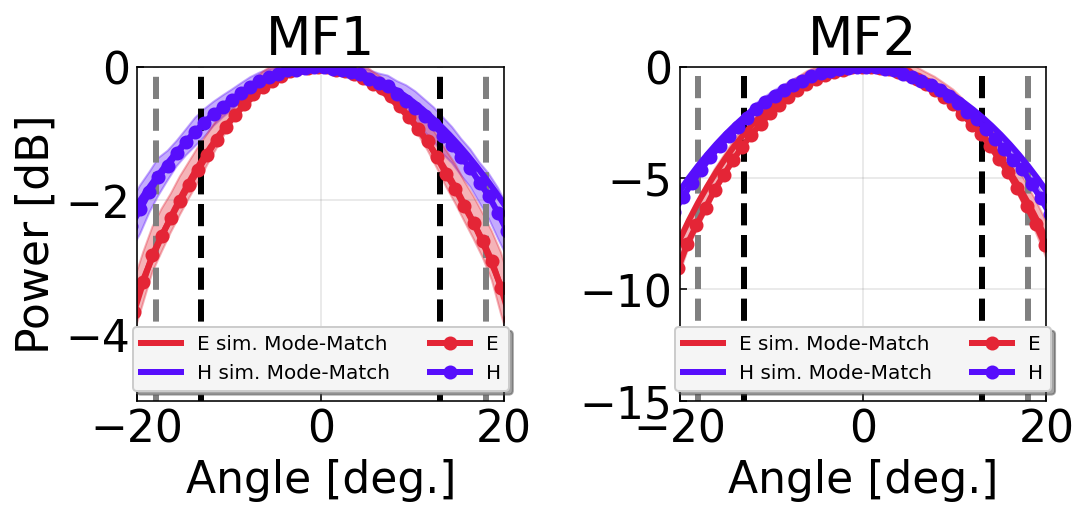

In [23]:
view = 'narrow'
alpha = .35

# bad = 94,95,99,109,105,106,107
import glob

if view=='wide':
    fig, ax = plt.subplots(1, 2,figsize = (8,4),sharey=True)
    markersize = 8
    linewidth = 2
else:
    fig, ax = plt.subplots(1, 2,figsize = (8,4),sharey=False)
    markersize = 12
    linewidth = 3
    
freq = [85,86,87,88,89,90,91,92,93,96,97,98,101,102,103,108]
# thet_sim,band_tot_E_sim,band_tot_H_sim,thet_e1_A,band_tot_E,\
#     thet_h1_A,band_tot_H,band_tot_E_lin,std_E,band_tot_H_lin,std_H = beam_avg(freq,0)
# ax[0].plot(thet_sim,band_tot_E_sim,'-',label = "E sim. HFSS",color = e_col,linewidth = linewidth)         
# ax[0].plot(thet_sim,band_tot_H_sim,'-',label = "H sim. HFSS",color = h_col,linewidth = linewidth)
thet_sim,band_tot_E_sim,band_tot_H_sim,thet_e1_A,band_tot_E,\
    thet_h1_A,band_tot_H,band_tot_E_lin,std_E,band_tot_H_lin,std_H = beam_avg(freq,1)
ax[0].plot(thet_sim,band_tot_E_sim,'-',label = "E sim. Mode-Match",color = e_col,linewidth = linewidth)         
ax[0].plot(thet_sim,band_tot_H_sim,'-',label = "H sim. Mode-Match",color = h_col,linewidth = linewidth)
 
ax[0].plot(thet_e1_A+.5,band_tot_E-np.max(band_tot_E),'.-',label = "E",color = e_col,linewidth = linewidth,markersize=markersize)         
ax[0].plot(thet_h1_A+.5,band_tot_H-np.max(band_tot_H),'.-',label = "H",color = h_col,linewidth = linewidth,markersize=markersize)
ax[0].fill_between(thet_h1_A+.5,20*np.log10(band_tot_H_lin - std_H),20*np.log10(band_tot_H_lin + std_H),color = h_col,alpha = alpha)
ax[0].fill_between(thet_e1_A+.5,20*np.log10(band_tot_E_lin - std_E),20*np.log10(band_tot_E_lin + std_E),color = e_col,alpha = alpha)

plt.xlim(-60,60)
plt.ylim(-35,0)


freq = [138,139,140,149,159,160]


# thet_sim,band_tot_E_sim,band_tot_H_sim,thet_e1_A,band_tot_E,\
#     thet_h1_A,band_tot_H,band_tot_E_lin,std_E,band_tot_H_lin,std_H = beam_avg(freq,0)
# ax[1].plot(thet_sim,band_tot_E_sim,'-',label = "E sim. HFSS",color = e_col,linewidth = linewidth)         
# ax[1].plot(thet_sim,band_tot_H_sim,'-',label = "H sim. HFSS",color = h_col,linewidth = linewidth)
thet_sim,band_tot_E_sim,band_tot_H_sim,thet_e1_A,band_tot_E,\
    thet_h1_A,band_tot_H,band_tot_E_lin,std_E,band_tot_H_lin,std_H = beam_avg(freq,1)
ax[1].plot(thet_sim,band_tot_E_sim,'-',label = "E sim. Mode-Match",color = e_col,linewidth = linewidth)         
ax[1].plot(thet_sim,band_tot_H_sim,'-',label = "H sim. Mode-Match",color = h_col,linewidth = linewidth)

ax[1].plot(thet_e1_A-.5,band_tot_E,'.-',label = "E",color = e_col,linewidth = linewidth,markersize=markersize)         
ax[1].plot(thet_h1_A-.5,band_tot_H,'.-',label = "H",color = h_col,linewidth = linewidth,markersize=markersize)
ax[1].fill_between(thet_h1_A-.5,20*np.log10(band_tot_H_lin - std_H),20*np.log10(band_tot_H_lin + std_H),color = h_col,alpha = alpha)
ax[1].fill_between(thet_e1_A-.5,20*np.log10(band_tot_E_lin - std_E),20*np.log10(band_tot_E_lin + std_E),color = e_col,alpha = alpha)

ax[0].set_title("MF1")
ax[1].set_title("MF2")
ax[0].set_ylabel("Power [dB]")
ax[0].set_xlabel("Angle [deg.]")
ax[1].set_xlabel("Angle [deg.]")

linestyle = 'dashed'
color_sat = 'k'
color_lat = 'grey'
ax[0].vlines(x=-13,ymin = -60,ymax = 5,linewidth = 3,color = color_sat,linestyle = linestyle)
ax[0].vlines(x=13,ymin = -60,ymax = 5,linewidth = 3,color = color_sat,linestyle = linestyle)
ax[0].vlines(x=-18,ymin = -60,ymax = 5,linewidth = 3,color = color_lat,linestyle = linestyle)
ax[0].vlines(x=18,ymin = -60,ymax = 5,linewidth = 3,color = color_lat,linestyle = linestyle)
ax[1].vlines(x=-13,ymin = -60,ymax = 5,linewidth = 3,color = color_sat,linestyle = linestyle)
ax[1].vlines(x=13,ymin = -60,ymax = 5,linewidth = 3,color = color_sat,linestyle = linestyle)
ax[1].vlines(x=-18,ymin = -60,ymax = 5,linewidth = 3,color = color_lat,linestyle = linestyle)
ax[1].vlines(x=18,ymin = -60,ymax = 5,linewidth = 3,color = color_lat,linestyle = linestyle)

if view=='wide':
    ax[1].set_xlim(-60,60)
    ax[1].set_ylim(-45,0)
    ax[0].set_xlim(-60,60)
    ax[0].set_ylim(-45,0)
    ax[0].legend(shadow=True, facecolor="whitesmoke",fontsize = 14,loc = 8,ncol=2,markerscale=2)
    ax[1].legend(shadow=True, facecolor="whitesmoke",fontsize = 14,loc = 8,ncol=2,markerscale=2)

else:
    ax[1].set_xlim(-20,20)
    ax[1].set_ylim(-15,0)
    ax[0].set_xlim(-20,20)
    ax[0].set_ylim(-5,0) 
    ax[0].legend(shadow=True, facecolor="whitesmoke",fontsize = 10,loc = 8,ncol=2,markerscale=1)
    ax[1].legend(shadow=True, facecolor="whitesmoke",fontsize = 10,loc = 8,ncol=2,markerscale=1)
    
plt.tight_layout(h_pad=1.0)
plt.savefig("1d_beammap_narrow.png",bbox_inches='tight')
plt.show()

<ipython-input-22-d2d4afb64c26>:29: RuntimeWarning: divide by zero encountered in log10
  return theta_full,20*np.log10((H_full)),20*np.log10((E_full))


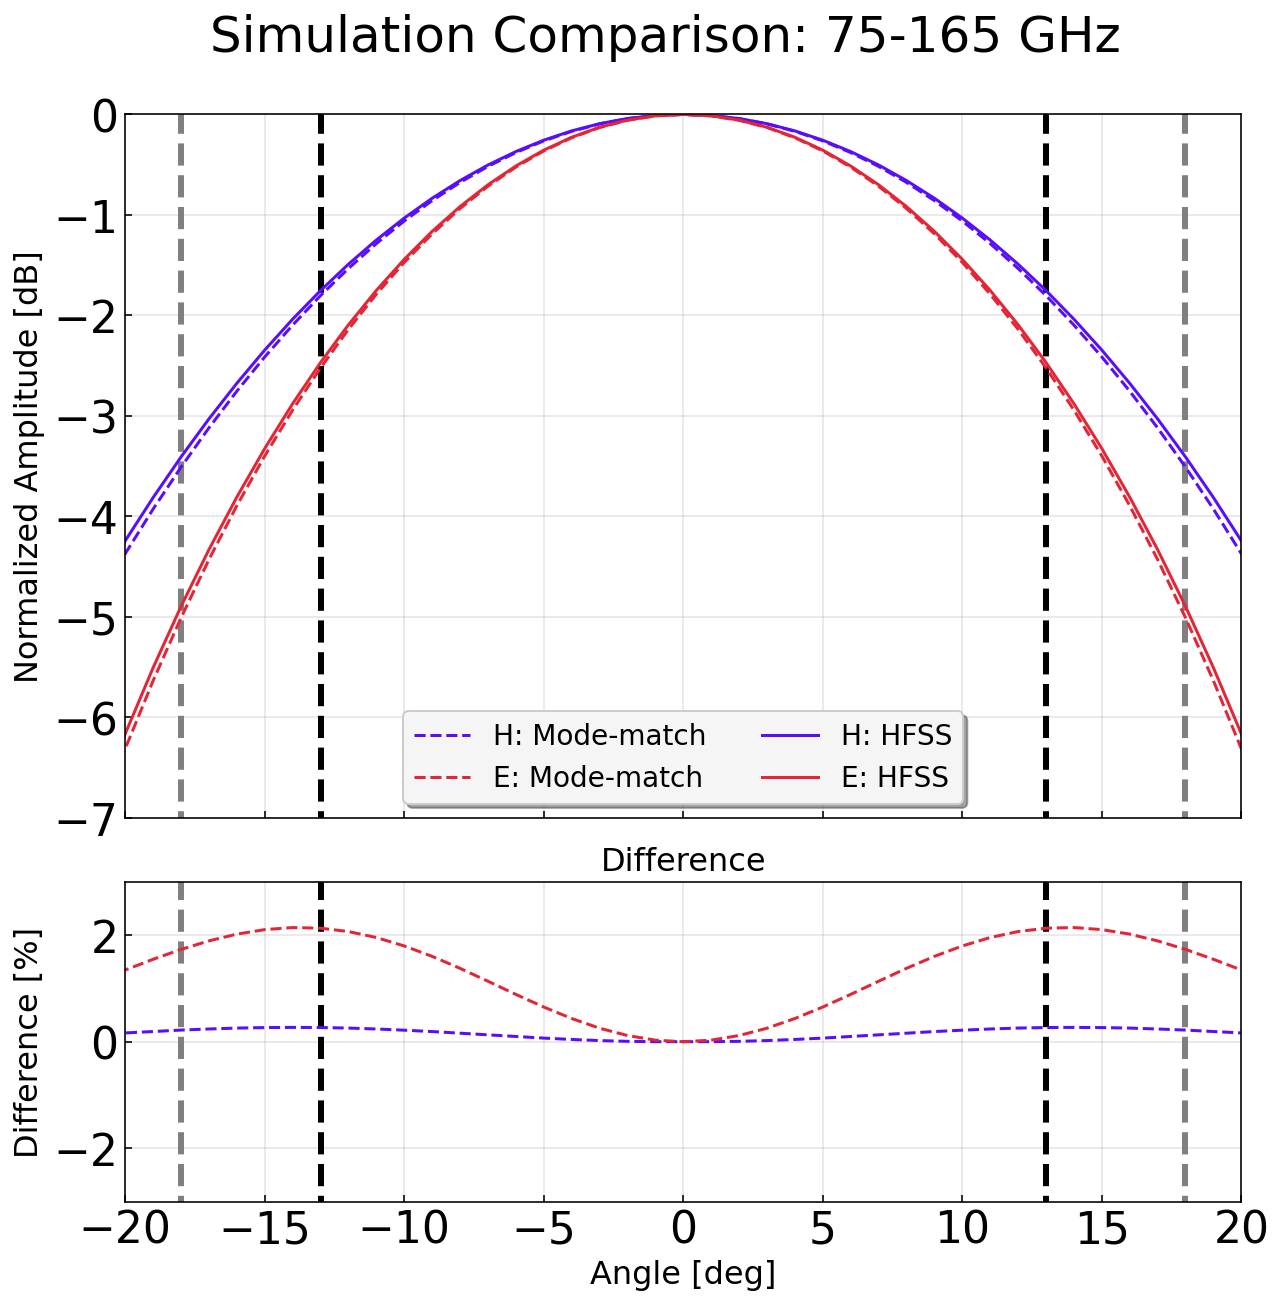

In [24]:
def annotate_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)

fig = plt.figure(figsize = (10,10))
ax1 = plt.subplot2grid((3, 3), (0, 0), rowspan=2,colspan=3)
ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=3,sharex=ax1)

freq = np.linspace(75,165,91)
h_hfss = []
e_hfss = []
h_mode = []
e_mode = []
for ff in freq:

    theta_full,H_full,E_full = sim_analytic(ff,opt = 1)

    h_hfss.append(H_full)
    e_hfss.append(E_full)

    theta_full,H_full,E_full = sim_analytic(ff,opt = 0)

    h_mode.append(H_full)
    e_mode.append(E_full)

    theta_full,H_full,E_full = sim_analytic(ff,opt = 1)
    diff_H = 10**(H_full/10)
    diff_E = 10**(E_full/10)
    theta_full,H_full,E_full = sim_analytic(ff,opt = 0)
    diff_H-= 10**(H_full/10)
    diff_E-= 10**(E_full/10)

h_mode_tot = np.mean(h_mode,axis = 0)
e_mode_tot = np.mean(e_mode,axis = 0)
h_hfss_tot = np.mean(h_hfss,axis = 0)
e_hfss_tot = np.mean(e_hfss,axis = 0)

ax1.plot(theta_full,h_mode_tot,'--',color = h_col,label = "H: Mode-match")
ax1.plot(theta_full,e_mode_tot,'--',color = e_col,label = "E: Mode-match")
ax1.plot(theta_full,h_hfss_tot,color = h_col,label = 'H: HFSS')
ax1.plot(theta_full,e_hfss_tot,color = e_col,label = 'E: HFSS')

ax2.plot(theta_full,(diff_H)*100,'--',color = h_col,label = "HFSS - Mode-match")
ax2.plot(theta_full,(diff_E)*100,'--',color = e_col,label = "HFSS - Mode-match")

plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel("Normalized Amplitude [dB]",fontsize = 16)
ax2.set_ylabel("Difference [%]",fontsize = 16)
ax2.set_xlabel("Angle [deg]",fontsize = 16)
ax2.set_title("Difference",fontsize = 16)
plt.suptitle("Simulation Comparison: 75-165 GHz",fontsize = 25,y=.95)
ax1.legend(shadow=True, facecolor="whitesmoke",fontsize = 14,loc = 8,ncol=2,markerscale=1)

ax1.vlines(x=-13,ymin = -60,ymax = 5,linewidth = 3,color = color_sat,linestyle = linestyle)
ax1.vlines(x=13,ymin = -60,ymax = 5,linewidth = 3,color = color_sat,linestyle = linestyle)
ax1.vlines(x=-18,ymin = -60,ymax = 5,linewidth = 3,color = color_lat,linestyle = linestyle)
ax1.vlines(x=18,ymin = -60,ymax = 5,linewidth = 3,color = color_lat,linestyle = linestyle)
ax2.vlines(x=-13,ymin = -60,ymax = 5,linewidth = 3,color = color_sat,linestyle = linestyle)
ax2.vlines(x=13,ymin = -60,ymax = 5,linewidth = 3,color = color_sat,linestyle = linestyle)
ax2.vlines(x=-18,ymin = -60,ymax = 5,linewidth = 3,color = color_lat,linestyle = linestyle)
ax2.vlines(x=18,ymin = -60,ymax = 5,linewidth = 3,color = color_lat,linestyle = linestyle)
ax1.set_ylim(-7,0)
ax2.set_ylim(-3,3)
ax1.set_xlim(-20,20)
ax2.set_xlim(-20,20)

plt.show()

### Compare to Simulations

FWHM of sim E:  37.25
FWHM of sim H:  48.63
FWHM of E: 37.370000 +/- 0.030000
FWHM of H: 46.110000 +/- 0.030000
FWHM of sim E:  25.52
FWHM of sim H:  29.46
FWHM of E: 25.340000 +/- 0.030000
FWHM of H: 28.460000 +/- 0.010000


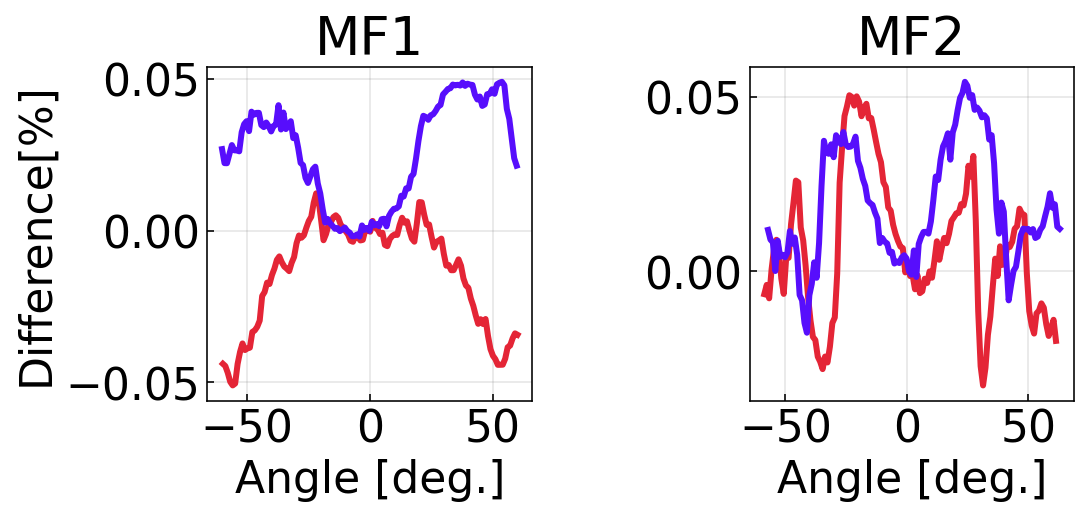

In [27]:
view = 'narrow'
alpha = .35

# bad = 94,95,99,109,105,106,107
import glob

if view=='wide':
    fig, ax = plt.subplots(1, 2,figsize = (8,4),sharey=True)
    markersize = 8
    linewidth = 2
else:
    fig, ax = plt.subplots(1, 2,figsize = (8,4),sharey=False)
    markersize = 12
    linewidth = 3
    
freq = [85,86,87,88,89,90,91,92,93,96,97,98,101,102,103,108]

thet_sim,band_tot_E_sim,band_tot_H_sim,thet_e1_A,band_tot_E,\
    thet_h1_A,band_tot_H,band_tot_E_lin,std_E,band_tot_H_lin,std_H = beam_avg(freq,1)

def interp1d_sim(x,y,x_new):
    y_new = interp1d(x,y,kind='cubic')(x_new)
    return y_new

band_tot_E_sim = interp1d_sim(thet_sim[np.where(thet_sim!=0)]-.5,band_tot_E_sim[np.where(thet_sim!=0)],thet_e1_A)
band_tot_H_sim = interp1d_sim(thet_sim[np.where(thet_sim!=0)]-.5,band_tot_H_sim[np.where(thet_sim!=0)],thet_h1_A)
band_tot_E_sim -= np.max(band_tot_E_sim)
band_tot_H_sim -= np.max(band_tot_H_sim)
ax[0].plot(thet_e1_A,10**(band_tot_E_sim/20)-10**(band_tot_E/20),'-',label = "E sim. HFSS",color = e_col,linewidth = linewidth)         
ax[0].plot(thet_h1_A,10**(band_tot_H_sim/20)-10**(band_tot_H/20),'-',label = "H sim. HFSS",color = h_col,linewidth = linewidth)

# plt.xlim(-60,60)
# plt.ylim(-35,0)

# def interp1d_sim(x,y,x_new):
#     y_new = interp1d(x,y,kind='cubic')(x_new)
#     return y_new

freq = [138,139,140,149,159,160]

thet_sim,band_tot_E_sim,band_tot_H_sim,thet_e1_A,band_tot_E,\
    thet_h1_A,band_tot_H,band_tot_E_lin,std_E,band_tot_H_lin,std_H = beam_avg(freq,1)

band_tot_E_sim = interp1d_sim(thet_sim[np.where(thet_sim!=0)]+.5,band_tot_E_sim[np.where(thet_sim!=0)],thet_e1_A)
band_tot_H_sim = interp1d_sim(thet_sim[np.where(thet_sim!=0)]+.5,band_tot_H_sim[np.where(thet_sim!=0)],thet_h1_A)
band_tot_E_sim -= np.max(band_tot_E_sim)
band_tot_H_sim -= np.max(band_tot_H_sim)
ax[1].plot(thet_e1_A,10**(band_tot_E_sim/20)-10**(band_tot_E/20),'-',label = "E sim. HFSS",color = e_col,linewidth = linewidth)         
ax[1].plot(thet_h1_A,10**(band_tot_H_sim/20)-10**(band_tot_H/20),'-',label = "H sim. HFSS",color = h_col,linewidth = linewidth)

# thet_sim,band_tot_E_sim,band_tot_H_sim,thet_e1_A,band_tot_E,\
#     thet_h1_A,band_tot_H,band_tot_E_lin,std_E,band_tot_H_lin,std_H = beam_avg(freq,1)
# ax[1].plot(thet_sim,band_tot_E_sim,'-',label = "E sim. Mode-Match",color = e_col,linewidth = linewidth)         
# ax[1].plot(thet_sim,band_tot_H_sim,'-',label = "H sim. Mode-Match",color = h_col,linewidth = linewidth)

# ax[1].plot(thet_e1_A,band_tot_E,'.-',label = "E",color = e_col,linewidth = linewidth,markersize=markersize)         
# ax[1].plot(thet_h1_A,band_tot_H,'.-',label = "H",color = h_col,linewidth = linewidth,markersize=markersize)

ax[0].set_title("MF1")
ax[1].set_title("MF2")
ax[0].set_ylabel("Difference[%]")
ax[0].set_xlabel("Angle [deg.]")
ax[1].set_xlabel("Angle [deg.]")

linestyle = 'dashed'
color_sat = 'k'
color_lat = 'grey'
# ax[0].vlines(x=-13,ymin = -60,ymax = 5,linewidth = 3,color = color_sat,linestyle = linestyle)
# ax[0].vlines(x=13,ymin = -60,ymax = 5,linewidth = 3,color = color_sat,linestyle = linestyle)
# ax[0].vlines(x=-18,ymin = -60,ymax = 5,linewidth = 3,color = color_lat,linestyle = linestyle)
# ax[0].vlines(x=18,ymin = -60,ymax = 5,linewidth = 3,color = color_lat,linestyle = linestyle)
# ax[1].vlines(x=-13,ymin = -60,ymax = 5,linewidth = 3,color = color_sat,linestyle = linestyle)
# ax[1].vlines(x=13,ymin = -60,ymax = 5,linewidth = 3,color = color_sat,linestyle = linestyle)
# ax[1].vlines(x=-18,ymin = -60,ymax = 5,linewidth = 3,color = color_lat,linestyle = linestyle)
# ax[1].vlines(x=18,ymin = -60,ymax = 5,linewidth = 3,color = color_lat,linestyle = linestyle)

# if view=='wide':
#     ax[1].set_xlim(-60,60)
#     ax[1].set_ylim(-45,0)
#     ax[0].set_xlim(-60,60)
#     ax[0].set_ylim(-45,0)
#     ax[0].legend(shadow=True, facecolor="whitesmoke",fontsize = 14,loc = 8,ncol=2,markerscale=2)
#     ax[1].legend(shadow=True, facecolor="whitesmoke",fontsize = 14,loc = 8,ncol=2,markerscale=2)

# else:
#     ax[1].set_xlim(-20,20)
#     ax[1].set_ylim(-15,0)
#     ax[0].set_xlim(-20,20)
#     ax[0].set_ylim(-5,0) 
#     ax[0].legend(shadow=True, facecolor="whitesmoke",fontsize = 10,loc = 8,ncol=2,markerscale=1)
#     ax[1].legend(shadow=True, facecolor="whitesmoke",fontsize = 10,loc = 8,ncol=2,markerscale=1)
    
plt.tight_layout(h_pad=1.0)
plt.savefig("diff_beam_avg_mf.png",bbox_inches='tight')
plt.show()